In [1]:
# Загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm 
from scipy.stats import *
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

## Загрузка данных

Выберем период исследования с января 2020 года по декабрь 2021 года.\
Для построения моделей нужны ежемесячно зафиксированные значения:
1. Инфляции, источник: [ЦБ РФ](https://www.cbr.ru/hd_base/infl/).
2. Денежной базы, источник: [ЦБ РФ](https://www.cbr.ru/hd_base/mb_nd/mb_nd_month/?UniDbQuery.Posted=True&UniDbQuery.From=01.2014&UniDbQuery.To=01.2023).
3. Среднего номинального курса доллара, источник: [ЕМИСС](https://www.fedstat.ru/indicator/42108).
4. Ключевой ставки, источник: [ЦБ РФ](https://www.cbr.ru/hd_base/infl/).

In [2]:
# Загрузка значений денежной массы:
url = 'https://www.cbr.ru/hd_base/mb_nd/mb_nd_month/?UniDbQuery.Posted=True&UniDbQuery.From=01.2014&UniDbQuery.To=12.2021'

money_supply = pd.read_html(io=url)[0][['Денежная база']].loc[::-1].reset_index(drop=True)
money_supply.columns = ['Денежная база']
money_supply['Денежная база'] = pd.to_numeric(
    money_supply['Денежная база'].str.replace(' ', '').str.replace(',', '.'))

In [3]:
# Загрузка значений инфляции и ключевой ставки:
file_name = 'Инфляция и ключевая ставка 01_01_2014__01_12_2021.xlsx'

infl_perc = pd.read_excel(file_name)[
    ['Дата', 'Ключевая ставка, % годовых', 'Инфляция, % г/г']
].loc[::-1].reset_index(drop=True)

In [4]:
# Загрузка значений среднего номинального курса доллара:
exchange = pd.read_excel(
    'Средний номинальный курс доллара 01_01_2014__01_12_2021.xls', 
    sheet_name='Данные', 
    skiprows=2,
    nrows=96)[['Доллар США по отношению к рублю']]

In [5]:
# Соединение всех данных в одну таблицу:
data = pd.concat([infl_perc, money_supply, exchange], axis=1)
data = data.iloc[72:].reset_index(drop=True)
data

,Дата,"Ключевая ставка, % годовых","Инфляция, % г/г",Денежная база,Доллар США по отношению к рублю
0,1.2020,6.25,2.40,10979.7,61.7808
1,2.2020,6.00,2.30,10609.1,63.8776
2,3.2020,6.00,2.50,10814.2,73.1480
3,4.2020,5.50,3.10,11536.7,75.2169
4,5.2020,5.50,3.00,12111.8,72.6110
5,6.2020,4.50,3.20,12378.9,69.2217
6,7.2020,4.25,3.40,12792.0,71.2825
7,8.2020,4.25,3.60,12996.3,73.7970
8,9.2020,4.25,3.70,13128.7,75.6513
9,10.2020,4.25,4.00,13235.0,77.5887


In [6]:
data.to_excel("data.xlsx")

In [35]:
data.describe()

,Дата,"Ключевая ставка, % годовых","Инфляция, % г/г",Денежная база,Доллар США по отношению к рублю
count,24.000000,24.000000,24.000000,24.000000,24.000000
mean,6.702050,5.458333,5.029167,13141.529167,72.879629
std,3.526299,1.261182,1.945575,1155.959591,3.597015
min,1.202000,4.250000,2.300000,10609.100000,61.780800
25%,3.952025,4.250000,3.350000,12688.725000,72.566875
50%,6.702050,5.250000,5.050000,13462.350000,73.756700
75%,9.452075,6.312500,6.500000,14025.775000,74.386875
max,12.202100,8.500000,8.400000,14320.700000,77.588700


## Описательный анализ

Визуализируем график зависимости значений параметров от даты:

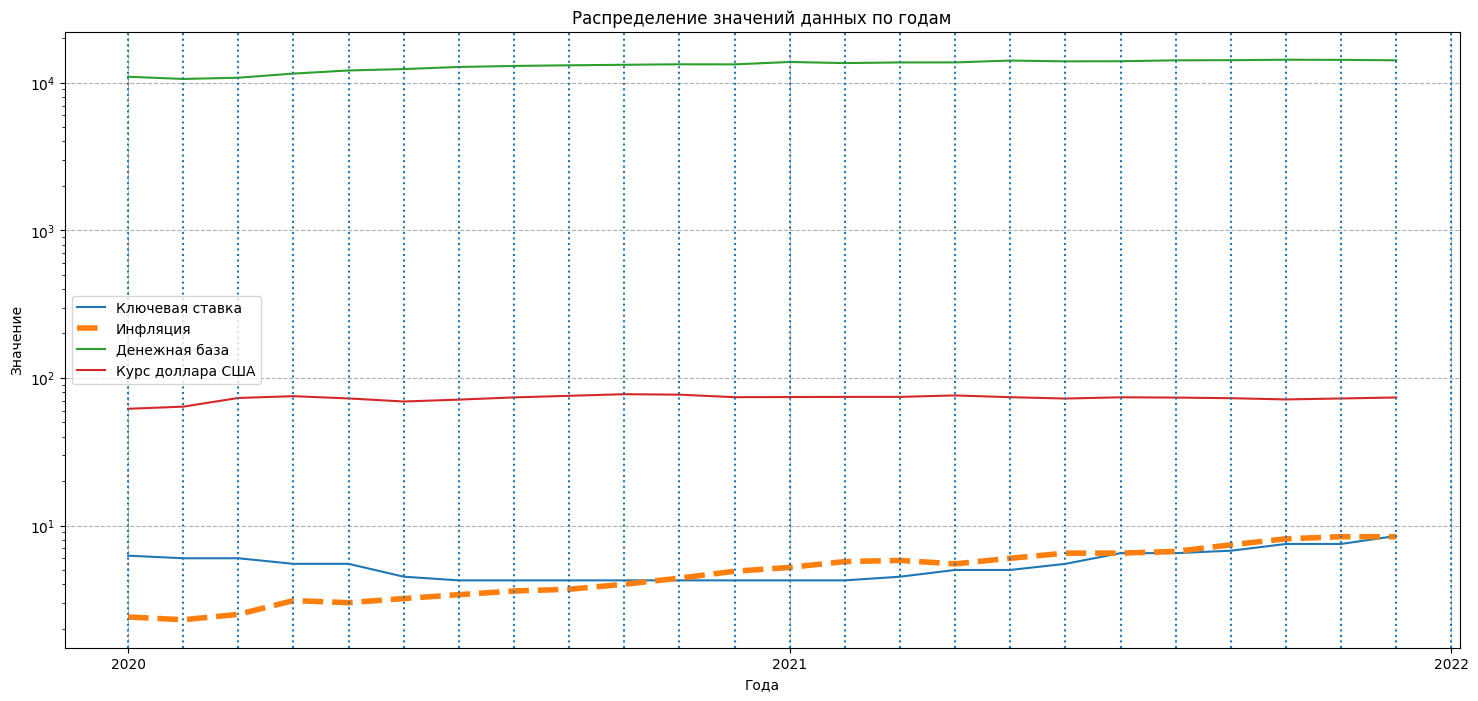

In [36]:
plt.figure(figsize=(18, 8))
plt.title('Распределение значений данных по годам')
plt.plot(data['Ключевая ставка, % годовых'], label='Ключевая ставка')
plt.plot(data['Инфляция, % г/г'], label='Инфляция', lw=4, linestyle='--')
plt.plot(data['Денежная база'], label='Денежная база')
plt.plot(data['Доллар США по отношению к рублю'], label='Курс доллара США')
for m in range(0, 25):
    plt.axvline(x=m, linestyle='dotted')
plt.legend()
plt.xlabel('Года')
plt.ylabel('Значение')
plt.yscale('log')
plt.xticks(range(0, 25, 12), [2020, 2021, 2022])
plt.grid(linestyle='--')
plt.show()

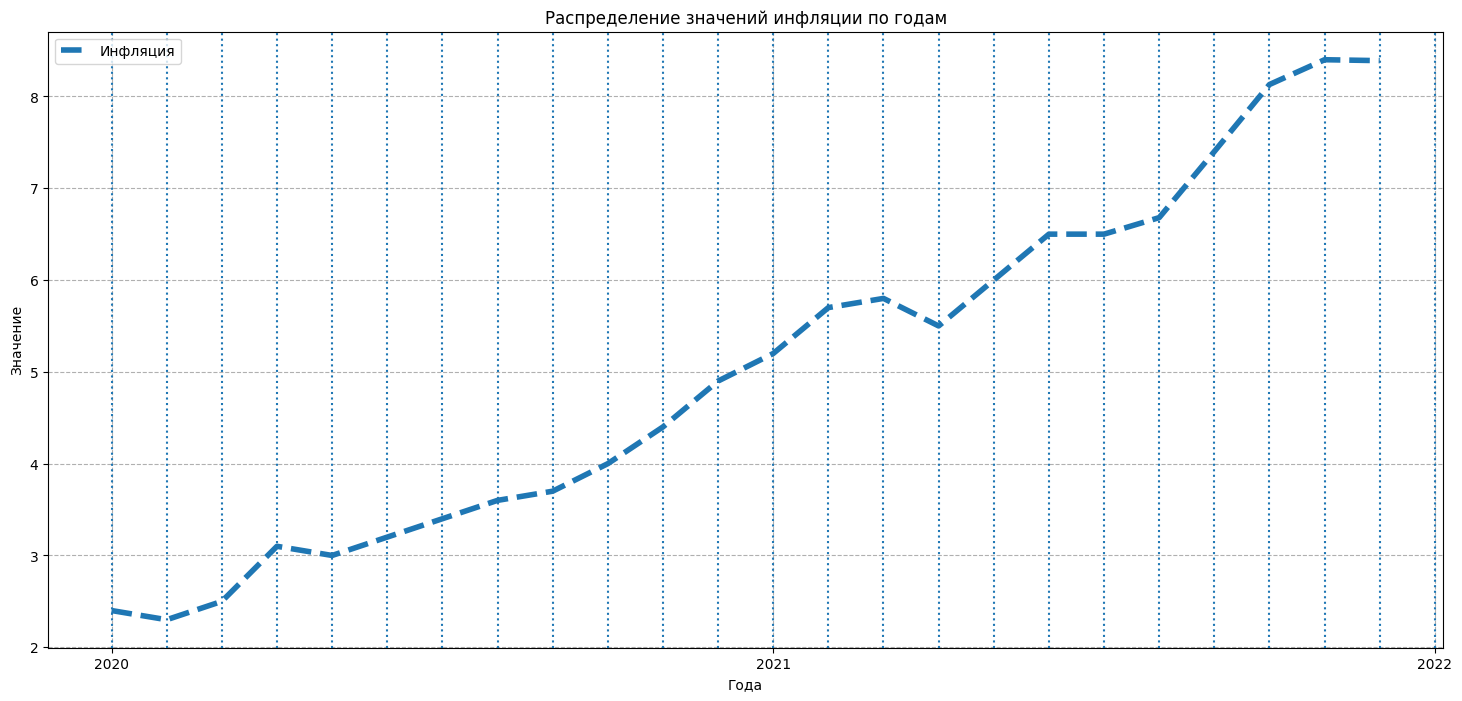

In [37]:
plt.figure(figsize=(18, 8))
plt.title('Распределение значений инфляции по годам')
plt.plot(data['Инфляция, % г/г'], label='Инфляция', lw=4, linestyle='--')
for m in range(0, 25):
    plt.axvline(x=m, linestyle='dotted')
plt.legend()
plt.xlabel('Года')
plt.ylabel('Значение')
plt.xticks(range(0, 25, 12), [2020, 2021, 2022])
plt.grid(linestyle='--')
plt.show()

Рассмотрим описательную статистику по каждому столбцу из таблицы:

In [38]:
data.describe()

,Дата,"Ключевая ставка, % годовых","Инфляция, % г/г",Денежная база,Доллар США по отношению к рублю
count,24.000000,24.000000,24.000000,24.000000,24.000000
mean,6.702050,5.458333,5.029167,13141.529167,72.879629
std,3.526299,1.261182,1.945575,1155.959591,3.597015
min,1.202000,4.250000,2.300000,10609.100000,61.780800
25%,3.952025,4.250000,3.350000,12688.725000,72.566875
50%,6.702050,5.250000,5.050000,13462.350000,73.756700
75%,9.452075,6.312500,6.500000,14025.775000,74.386875
max,12.202100,8.500000,8.400000,14320.700000,77.588700


Видим, что пропущенных значений нет.

## Выбор модели, оценка параметров

В качестве модели рассмотрим линейное
регрессионное уравнение:
$$Y = \beta_0 + \beta_1 \cdot X_1 + \beta_2 \cdot X_2 + \beta_3 \cdot X_3 + \varepsilon $$
где $Y$ - объясняемая переменная (инфляция), a $X_1$, $X_2$, $X_3$ - объясняющие переменные (ключевая ставка, денежная база и курс доллара соотв.).\
$\beta_0$, $\beta_1$, $\beta_2$ - параметры регрессии, $\varepsilon$ - ошибка регресии.

Выделим признаки и целевую переменную из данных.

In [7]:
Y = data[['Инфляция, % г/г']].rename(columns={'Инфляция, % г/г': 'Y'})
X = data.rename(
    columns={'Ключевая ставка, % годовых': 'X1', 
             'Денежная база': 'X2', 
             'Доллар США по отношению к рублю': 'X3'}
).drop(['Инфляция, % г/г', 'Дата'], axis=1)

Оценим параметры уравнения регрессии с помощью метода наименьших квадратов:

In [8]:
X_ = sm.add_constant(X)
reg = sm.OLS(Y, X_).fit() 
b0, b1, b2, b3 = reg.params
print(f'beta_0 = {b0}\nbeta_1 = {b1}\nbeta_2 = {b2}\nbeta_3 = {b3}')

beta_0 = -16.117260406018282
beta_1 = 0.6626650447765302
beta_2 = 0.0013898856077517946
beta_3 = -0.010096674352895296


In [9]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     161.6
Date:                Wed, 31 May 2023   Prob (F-statistic):           3.45e-14
Time:                        09:58:46   Log-Likelihood:                -10.773
No. Observations:                  24   AIC:                             29.55
Df Residuals:                      20   BIC:                             34.26
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.1173      2.023     -7.965      0.0

## Анализ и оценка модели

Приверим соблюдение условий Гаусса-Маркова:

1. Математическое ожидание ошибок регрессии равно 0

In [10]:
reg.resid.mean()

1.556199613617082e-12

Первое условие Гаусса-Маркова соблюдается.

2. Дисперсия случайных отклонений постоянна (наличие гомоскедастичности)

Проверим данные на наличие/отсутствии гомоскедастичности. Для проверки будем использовать тест Голдфелда — Куандта.\
Вычислим p-value:

In [11]:
p_value = sm.stats.diagnostic.het_goldfeldquandt(Y, X, drop=0.33)
p_value

(0.744924908635317, 0.6911200142072762, 'increasing')

Так как значение p-value не меньше 0.05, мы не можем отвергнуть нулевую гипотезу о присутствии гомоскедастичности.

3. Случайные отклонения остатков независимы (отсутствие автокорреляции)

Для проверки данных на автокорреляцию вычислим статистику Дарбина-Уотсона:

In [12]:
DW = durbin_watson(reg.resid)
DW

1.280715738149678

In [13]:
1,10 	1,66

SyntaxError: invalid syntax (1421208862.py, line 1)

Так как значение статистики Дарбина-Уотсона близко к двум, это говорит об отсутствии автокорреляции.

4. Отсутствие мультиколлинеарности

Проверим данные на мультиколлинеарность. Для проверки проанализируем матрицу коэффициентов корреляции:

In [14]:
pd.concat([Y, X], axis=1).corr()

,Y,X1,X2,X3
Y,1.000000,0.558409,0.879614,0.314084
X1,0.558409,1.000000,0.149411,-0.292784
X2,0.879614,0.149411,1.000000,0.555244
X3,0.314084,-0.292784,0.555244,1.000000


In [15]:
import seaborn as sns

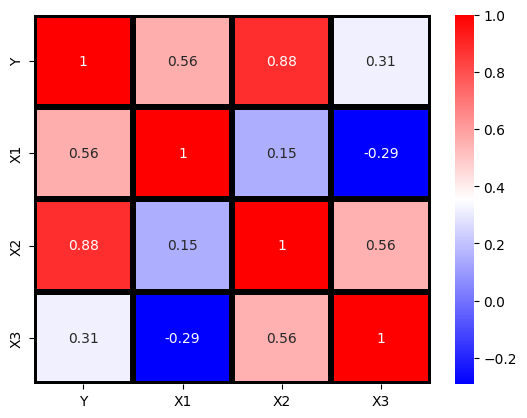

In [25]:
sns.heatmap(pd.concat([Y, X], axis=1).corr(), annot = True, cmap= 'bwr', linewidths=3, linecolor='black', square=False)
plt.show()

Видим, что величины ни одного из коэффциентов не превышает по модулю 0.75, что может говорить об отсутствии мультиколлинеарности. Для более точной провери воспользуемся VIF-тестом:

In [26]:
y, x = dmatrices('Y ~ X1+X2+X3', data=pd.concat([Y, X], axis=1), return_type='dataframe')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['Переменная'] = x.columns

vif

,VIF,Переменная
0,569.906034,Intercept
1,1.292713,X1
2,1.708676,X2
3,1.827160,X3


Т.к. все значения VIF меньше 10, мультиколлинеарность не наблюдается.

Проверим статистическую значимость уравнения рергесии в целом. Для этого воспользуемся *F*-критерием Фишера. Найдем расчетное значение критерия:
$$Q_r = B^T(X^TY) - n\bar{y}^2$$
$$Q_e = Y^TY - B^TX^TY$$
$$S_r^2 = \frac{Q_r}{p}$$
$$S_e^2 = \frac{Q_e}{n - p - 1}$$
$$F_p = \frac{S_r^2}{S_e^2}$$
И сравним его с табличным $F_{\alpha;p;n - p - 1}$\
Eсли $F_p \geq F_{\alpha;p;n - p - 1}$, то уравнение значимо.

In [35]:
n = len(Y)
p = 3
alpha = 0.05
B = reg.params.values
Q_r = np.dot(B.T, np.dot(X_.T.values, Y.values)) - n * Y.values.mean()**2
Q_e = np.dot(Y.T.values, Y.values) - np.dot(np.dot(B.T, X_.T.values), Y.values)
S_r = Q_r / p
S_e = Q_e / (n - p - 1)
F_p = S_r / S_e
F = f.isf(alpha, p, n - p - 1)
if F_p >= F:
    print('Уравнение регрессии в целом значимо')
else:
    print('Уравнение регрессии в целом незначимо')

Уравнение регрессии в целом значимо


In [36]:
F

3.09839121214078

In [37]:
F_p

array([[161.64577458]])

Для проверки статистической значимости коэффициентов регресии воспользуемся *t*-критерием Стьюдента. Для этого сначала найдем стандартные ошибки коэффициентов регрессии:
$$m_{b_i} = S_e\sqrt{[(X^TX)^{-1}]_{ii}}$$
Затем найдем наблюдаемые значения *t*-критерия:
$$t_{b_i} = \frac{b_i}{m_{b_i}}$$
И сравним их с табличным $t_{\alpha;n - p - 1}$\
Eсли $t_{b_i} \geq t_{\alpha;n - p - 1}$, то уравнение значимо.

In [38]:
matrix = np.linalg.inv(np.dot(X_.T.values, X_.values))
m_b0 = np.sqrt(S_e * matrix[0, 0])
m_b1 = np.sqrt(S_e * matrix[1, 1])
m_b2 = np.sqrt(S_e * matrix[2, 2])
m_b3 = np.sqrt(S_e * matrix[3, 3])
t_b0 = abs(B[0] / m_b0)
t_b1 = abs(B[1] / m_b1)
t_b2 = abs(B[2] / m_b2)
t_b3 = abs(B[3] / m_b3)
alpha = 0.05
t_ = t.isf(alpha, n - p - 1)
if t_b0 >= t_:
    print('Коэффицент b0 значим')
if t_b1 >= t_:
    print('Коэффицент b1 значим')
if t_b2 >= t_:
    print('Коэффицент b2 значим')
if t_b3 >= t_:
    print('Коэффицент b3 значим')

Коэффицент b0 значим
Коэффицент b1 значим
Коэффицент b2 значим


In [39]:
t_b0, t_b1, t_b2, t_b3

(array([[7.96530058]]),
 array([[8.48968563]]),
 array([[14.19589483]]),
 array([[0.3103153]]))

In [40]:
t_

1.7247182429207863

## Прогнозирование на основе полученной модели

Для проверки модели спрогнозируем темп инфляции в январе 2022 года.\
Для этого соберем информацию о значениях ключевой ставки, денежной базы и номинального курса доллара за этот период:

In [41]:
inf = 8.73
perc = 8.5
m_s = 14553.8
ec = 75.8682

In [42]:
pd.DataFrame({'Инфляция': inf, 'Ключевая ставка, % годовых': perc, 
             'Денежная база': m_s, 
             'Доллар США по отношению к рублю': ec}, index=[0])

,Инфляция,"Ключевая ставка, % годовых",Денежная база,Доллар США по отношению к рублю
0,8.73,8.5,14553.8,75.8682


Подставим эти данные в нашу модель:

In [43]:
X_p = np.array([1, perc, m_s, ec])
y_hat = (X_p * B).sum()
y_hat

8.977493123539963

Рассчитаем 95%-ный доверительный интервал прогноза регрессии:

In [44]:
S_y_p = S_e**0.5 * np.sqrt(1 + np.dot(np.dot(X_p.T, np.linalg.inv(np.dot(X_.values.T, X_.values))), X_p))
[y_hat - S_y_p*t_, y_hat + S_y_p*t_]

[array([[8.1275585]]), array([[9.82742775]])]

In [51]:
reg.predict(X_).values

array([2.66114251, 1.95921394, 2.15067927, 2.80265009, 3.62828422,
       3.37107828, 3.75876654, 4.01733208, 4.18263067, 4.31081422,
       4.45471856, 4.45953698, 5.16661879, 4.83690484, 5.19240556,
       5.51411077, 6.0960488 , 6.19713481, 6.88685224, 7.16490899,
       7.38116553, 8.03503081, 7.97728085, 8.49469067])

In [53]:
data['Инфляция, % г/г'].values

array([2.4 , 2.3 , 2.5 , 3.1 , 3.  , 3.2 , 3.4 , 3.6 , 3.7 , 4.  , 4.4 ,
       4.9 , 5.2 , 5.7 , 5.8 , 5.5 , 6.  , 6.5 , 6.5 , 6.68, 7.4 , 8.13,
       8.4 , 8.39])

In [55]:
pd.DataFrame({'Фактические значения': data['Инфляция, % г/г'].values, 'Предсказанные значения': reg.predict(X_).values}).to_excel("predict.xlsx")

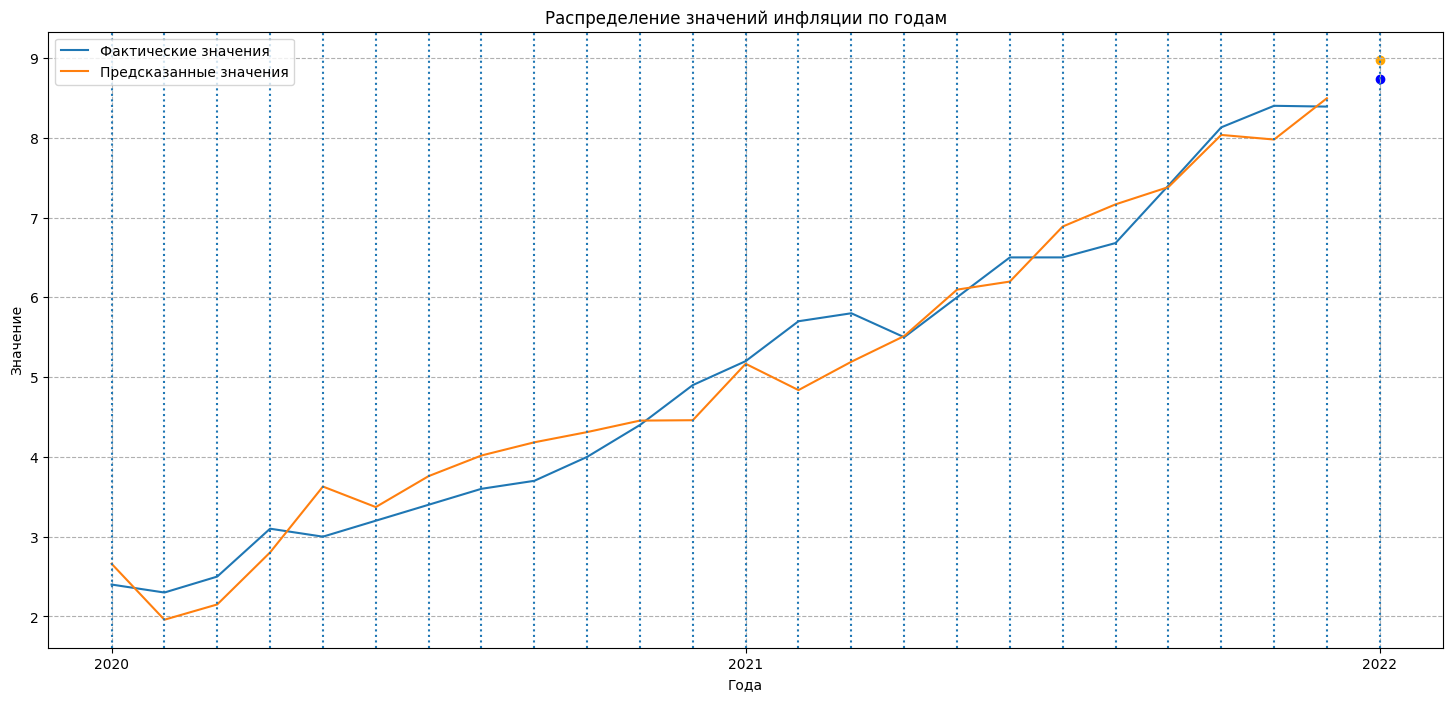

In [26]:
plt.figure(figsize=(18, 8))
plt.title('Распределение значений инфляции по годам')
plt.plot(data['Инфляция, % г/г'], label='Фактические значения')
plt.plot(reg.predict(X_), label='Предсказанные значения')
for m in range(0, 25):
    plt.axvline(x=m, linestyle='dotted')
plt.scatter(24, y_hat, color='orange')
plt.scatter(24, inf, color='blue')
plt.legend()
plt.xlabel('Года')
plt.ylabel('Значение')
plt.xticks(range(0, 25, 12), [2020, 2021, 2022])
plt.grid(linestyle='--')
plt.show()

In [28]:
for i in B:
    print(i)

-16.117260406018282
0.6626650447765302
0.0013898856077517946
-0.010096674352895296


In [30]:
data

,Дата,"Ключевая ставка, % годовых","Инфляция, % г/г",Денежная база,Доллар США по отношению к рублю
0,1.2020,6.25,2.40,10979.7,61.7808
1,2.2020,6.00,2.30,10609.1,63.8776
2,3.2020,6.00,2.50,10814.2,73.1480
3,4.2020,5.50,3.10,11536.7,75.2169
4,5.2020,5.50,3.00,12111.8,72.6110
5,6.2020,4.50,3.20,12378.9,69.2217
6,7.2020,4.25,3.40,12792.0,71.2825
7,8.2020,4.25,3.60,12996.3,73.7970
8,9.2020,4.25,3.70,13128.7,75.6513
9,10.2020,4.25,4.00,13235.0,77.5887
